In [1]:
from datasets import load_dataset
import io
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import torch
from torch import float32, int64
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from Network.Mobilenet import *
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/taehwan/micromamba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("flwrlabs/femnist")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'writer_id', 'hsf_id', 'character'],
        num_rows: 814277
    })
})

In [3]:
dataframe = ds["train"]


In [6]:
dataframe = dataframe.to_pandas()
dataframe.head()

,image,writer_id,hsf_id,character
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,f0000_14,0,0
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,f0000_14,0,53
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,f0000_14,0,28
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,f0000_14,0,28
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,f0000_14,0,22


18


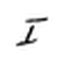

In [43]:
dataframe[dataframe["hsf_id"] == 7]["image"].iloc[7]
print(dataframe[dataframe["hsf_id"] == 7]["character"].iloc[7])
Image.open(io.BytesIO(dataframe[dataframe["hsf_id"] == 7]["image"].iloc[7]["bytes"])).resize((64,64), Image.LANCZOS)

Text(0.5, 1.0, 'Number of samples per client for FEMNIST')

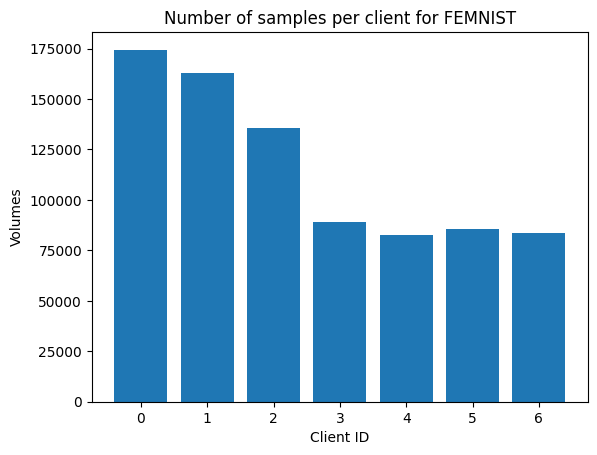

In [7]:
plt.bar(range(7), dataframe["hsf_id"].value_counts().sort_index())
plt.xlabel("Client ID")
plt.ylabel("Volumes")
plt.title("Number of samples per client for FEMNIST")

In [7]:
def eval(net, eval_loader, e, lossf, DEVICE, Central=False):
    net.eval()
    Dicenary = {'accuracy':0, 'f1score':0}
    length = 0
    losses = 0
    for sample in tqdm(eval_loader, desc="Evaluation: "):
    
        X= torch.stack([torch.Tensor(np.array(s.resize((64, 64), Image.LANCZOS))) for s in sample["image"]], 0)
        Y= torch.Tensor(sample["character"])
        if len(sample) != 1:
            out = net(torch.stack([X.type(float32).to(DEVICE),X.type(float32).to(DEVICE),X.type(float32).to(DEVICE)], 1).squeeze()) 
            losses += lossf(out.type(float32).to(DEVICE), Y.type(int64).to(DEVICE)).item()
        else:
            out = net(torch.stack([X.type(float32).to(DEVICE),X.type(float32).to(DEVICE),X.type(float32).to(DEVICE)], 1).squeeze().unsqueeze(0)) 
            losses += lossf(out.type(float32).to(DEVICE), Y.type(int64).to(DEVICE)).item()
        out = out.softmax(dim=1).argmax(dim=1)
        Dicenary[f"accuracy"] += accuracy_score(Y.type(int64).cpu().detach().numpy(), out.cpu().detach().numpy())
        Dicenary[f"f1score"] += f1_score(Y.type(int64).cpu().detach().numpy(), out.cpu().detach().numpy(), average='macro')
        length += 1
    # if Central:
        # logger.info(f"Result epoch {e+1}: loss:{losses/length} accuracy: {Dicenary["accuracy"]/length: .4f} f1score: {Dicenary["f1score"]/length: .4f}")
        
    return {"loss":losses/length, 'accuracy': Dicenary["accuracy"]/length , "f1score":Dicenary["f1score"]/length}
    # return {"loss": losses/length}

In [4]:
#FedAvg
net = MobileNet(62).to(DEVICE)
net.load_state_dict(torch.load("./Models/FedAvgFEMNIST/net.pt",weights_only=True))
net.eval()
eval(net, ds["train"].to_iterable_dataset().batch(256), 0, torch.nn.CrossEntropyLoss(), DEVICE, Central=False)

Evaluation: : 3181it [02:26, 21.67it/s]


{'loss': 4.099380430655073,
 'accuracy': 0.05144951579372767,
 'f1score': 0.001781506395410965}

In [4]:
#FedProx
net = MobileNet(62).to(DEVICE)
net.load_state_dict(torch.load("./Models/FedProxFEMNIST/net.pt",weights_only=True))
net.eval()
eval(net, ds["train"].to_iterable_dataset().batch(256), 0, torch.nn.CrossEntropyLoss(), DEVICE, Central=False)

Evaluation: : 3181it [02:31, 20.97it/s]


{'loss': 4.0953437225955795,
 'accuracy': 0.04860793688772327,
 'f1score': 0.001688812624885604}

In [8]:
#FedOpt
net = MobileNet(62).to(DEVICE)
net.load_state_dict(torch.load("./Models/FedOptFEMNIST/net.pt",weights_only=True))
net.eval()
eval(net, ds["train"].to_iterable_dataset().batch(256), 0, torch.nn.CrossEntropyLoss(), DEVICE, Central=False)

Evaluation: : 3181it [03:08, 16.84it/s]


{'loss': 4.097894165509154,
 'accuracy': 0.05144951579372767,
 'f1score': 0.001781506395410965}

In [5]:
#FedRef
net = MobileNet(62).to(DEVICE)
net.load_state_dict(torch.load("./Models/FedRefFEMNIST/net_lda0.1_p3_7.pt",weights_only=True))
net.eval()
eval(net, ds["train"].to_iterable_dataset().batch(256), 0, torch.nn.CrossEntropyLoss(), DEVICE, Central=False)

Evaluation: : 3181it [02:26, 21.77it/s]


{'loss': 3.9561338430678683,
 'accuracy': 0.05144951579372767,
 'f1score': 0.001781506395410965}

In [2]:
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
def ploting(fedavg, fedprox, fedref, title="MNIST Classification", zoom_min = 20, zoom_max=25, inset=True, metric="loss", minimum_y=0):
    # 예시 데이터
    tableau_colors = list(mcolors.TABLEAU_COLORS.values())
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fedavg[metric], marker=".",linestyle="--",label="fedavg", color=tableau_colors[0], alpha=1, linewidth=4)
    ax.plot(fedprox[metric], marker=".", linestyle="--" ,label="fedprox(μ:0.5)", color=tableau_colors[1], alpha=0.5, linewidth=4)
    for i,l in enumerate(fedref):
        ax.plot(l[metric], marker=".", label=l["label"], color=tableau_colors[i+2], linestyle="--", alpha=0.7, linewidth=4)

    # 메인 축 설정
    ax.set_title(title)
    ax.set_xlabel("Rounds")
    ax.set_ylabel(metric)
    ax.legend()
    # 🔍 확대 구간 설정 (마지막 x값 근처, 예: x > 90)
    x_zoom_min = zoom_min
    x_zoom_max = zoom_max

    # inset 축 생성
    if inset:
        axins = inset_axes(ax, width="30%", height="40%", loc='lower right')
        axins.plot(fedavg[metric], color =tableau_colors[0], label = "fedavg", marker=".", alpha=1, linestyle="--")
        axins.plot(fedprox[metric], color =tableau_colors[1], label = "fedprox", linestyle="--", marker= ".", alpha=0.7)
        for i,l in enumerate(fedref):
            axins.plot(l[metric], label=l["label"], color=tableau_colors[i+2], linestyle="--", marker=".")

        alp = fedavg[metric][zoom_min:zoom_max+1].to_list() + fedprox[metric][zoom_min:zoom_max+1].to_list()
        for l in fedref:
            alp = alp + l[metric][zoom_min:zoom_max+1].to_list()

        axins.set_xlim(x_zoom_min, x_zoom_max)
        #확대된 y축 범위도 지정하면 보기 쉬움
        #y_zoom = y[(x >= x_zoom_min) & (x <= x_zoom_max)]
        axins.set_ylim(bottom=min(alp), top = max(alp))
        
        # 확대된 영역 표시선 연결
        ax.indicate_inset_zoom(axins)
    ax.legend(fontsize=17)
        
    fig.show()

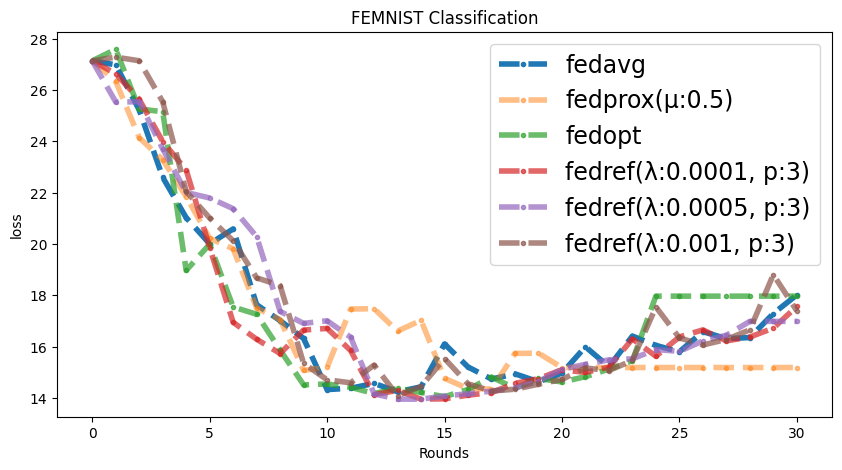

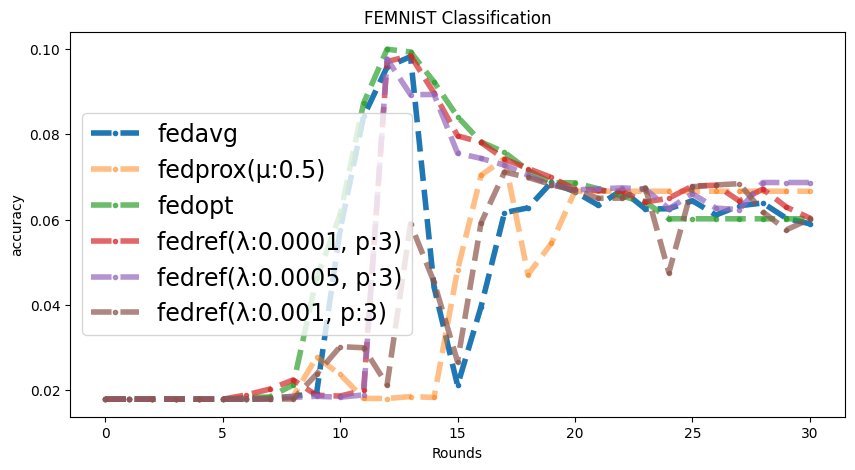

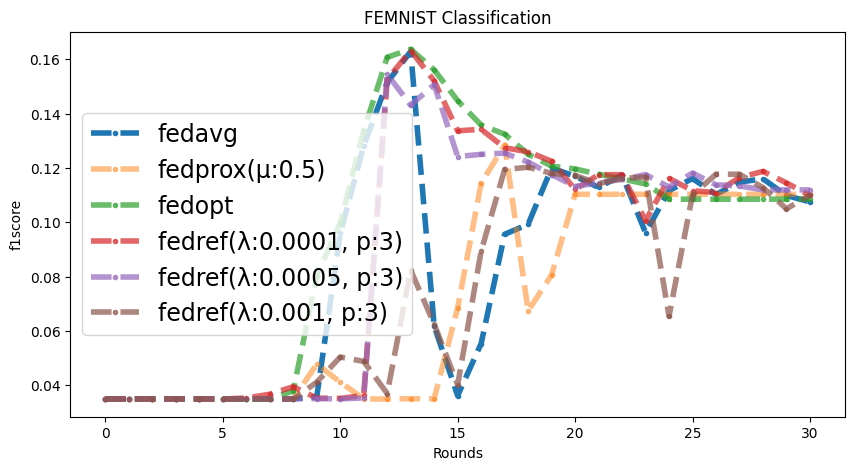

In [3]:
fedavg = pd.read_csv("./Result/fedavg/fedavg_femnist.csv")
fedprox = pd.read_csv("./Result/fedprox/fedprox_femnist.csv")
fedopt = pd.read_csv("./Result/fedopt/fedopt_femnist.csv")
fedref = [{**fedopt.to_dict("series"), **{"label":"fedopt"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda0.001_p3.csv").to_dict("series"), **{"label":"fedref(λ:0.0001, p:3)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda0.005_p3.csv").to_dict("series"), **{"label":"fedref(λ:0.0005, p:3)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda0.01_p3.csv").to_dict("series"), **{"label":"fedref(λ:0.001, p:3)"}},
    ]
ploting(fedavg, fedprox, fedref, title="FEMNIST Classification", zoom_min=20, zoom_max=25, inset=False, metric="loss", minimum_y=0.1)
ploting(fedavg, fedprox, fedref, title="FEMNIST Classification", zoom_min=20, zoom_max=25, inset=False, metric="accuracy", minimum_y=0.01)
ploting(fedavg, fedprox, fedref, title="FEMNIST Classification", zoom_min=20, zoom_max=25, inset=False, metric="f1score", minimum_y=0.1)
